In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
import os

BASE_DIR = r"C:\Users\admin\Desktop\price_pattern_cnn\data\candlestick_images"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
MODEL_PATH = os.path.join(r"C:\Users\admin\Desktop\price_pattern_cnn\models", "pattern_detector.h5")

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)

for path in [TRAIN_DIR, VAL_DIR]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory not found: {path}")


IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001

TRAIN_DIR: C:\Users\admin\Desktop\price_pattern_cnn\data\candlestick_images\train
VAL_DIR: C:\Users\admin\Desktop\price_pattern_cnn\data\candlestick_images\val


In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [41]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [42]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)
]

# ===============================
# 7. Train
# ===============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
1/1 [==============================] - 1s 979ms/step - loss: 0.7688 - accuracy: 0.0000e+00 - val_loss: 0.6708 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 241ms/step - loss: 1.5614 - accuracy: 0.5000 - val_loss: 0.8257 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 145ms/step - loss: 0.3591 - accuracy: 1.0000 - val_loss: 1.4179 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 146ms/step - loss: 1.7840 - accuracy: 0.5000 - val_loss: 0.9919 - val_accuracy: 0.5000


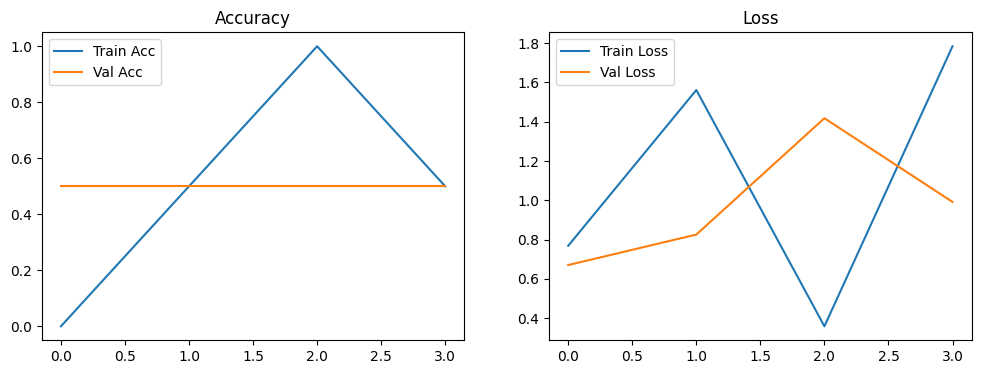

In [43]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()

In [44]:
model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")

Model saved at C:\Users\admin\Desktop\price_pattern_cnn\models\pattern_detector.h5


In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [5]:
model = load_model(r"C:\Users\admin\Desktop\price_pattern_cnn\models\pattern_detector.h5")

In [6]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # ✅ Resize to match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if required by your training
    return img_array

In [7]:
def predict(img_path):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)
    return predicted_class, confidence

In [8]:
img_path = "path/to/test_image.jpg"  # ⛳ Update this path to your test image
predicted_class, confidence = predict(img_path)

# 🧾 Step 6: Display Results
class_labels = ['Class A', 'Class B', 'Class C']  # ⛳ Replace with your actual class names

print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence * 100:.2f}%")

# 🖼️ Optional: Display the image
img_display = image.load_img(img_path)
plt.imshow(img_display)
plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/test_image.jpg'